# Content Dimension: text classification

### Features
* BoW
* TF-IDF
* W2V

In [1]:
import pandas as pd
from utils import preprocess
from sklearn.linear_model import LogisticRegression
import utils
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neural_network import MLPClassifier
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import numpy as np

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Load data

In [2]:
import pandas as pd

df_train = pd.read_csv('data/2018/train-test/train.csv')
df_test = pd.read_csv('data/2018/train-test/test.csv')


In [3]:
df_train

,text,misinformation,original,id_message,preprocessed_text
0,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,1,0,esquerdo acabar saber que \n stephen kanitz ar...
1,Leiam esse artigo \n\n\nA ESQUERDA ACABOU. SAI...,1,0,0,ler artigo \n \n \n esquerdo acabar saber que ...
2,A ESQUERDA ACABOU. SAIBA POR QUÊ?\npor Stephen...,1,0,0,esquerdo acabar saber que ? \n stephen kanitz ...
3,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...
4,A ESQUERDA ACABOU. SAIBA POR QUÊ.\npor Stephen...,1,0,0,esquerdo acabar saber que \n stephen kanitz \n...
...,...,...,...,...,...
6228,ATENÇÃO ELEITORES DE BOLSONARO EM BELÉM DO PAR...,0,1,3301,atarncao eleitor bolsonaro belem parar \n \n c...
6229,"""DITA DURA"".\n\nPara:\n""Ninguém é igual a ning...",1,1,3302,dizer duro \n \n \n ninguem igual ninguem todo...
6230,GRANDE CARLOS DRUMOND DE ANDRADE: ...,1,0,3302,grande carlos drumond andrade dizer duro \n \n...
6231,"CARLOS DRUMOND DE ANDRADE\n\nDITA DURA\n""Ningu...",1,0,3302,carlos drumond andrade \n \n dizer duro \n nin...


In [4]:
for t in df_train['text']:
    if 'facebook' in t:
        print(t)
        break

*BEM GALERA... O VIDEO DA PSICOLOGIA REVERSA PARA AJUDAR O NOSSO PRESIDENTE ESTÁ AQUI:*

https://m.facebook.com/story.php?story_fbid=525897467858283&id=243021376285804


In [5]:
df_train.groupby(by='misinformation').count()['text']

misinformation
0    3255
1    2978
Name: text, dtype: int64

In [6]:
df_train.groupby(by='misinformation')['original'].sum()

misinformation
0    1905
1    1399
Name: original, dtype: int64

In [7]:
df_test.groupby(by='misinformation').count()['text']

misinformation
0    834
1    740
Name: text, dtype: int64

In [8]:
df_test.groupby(by='misinformation')['original'].sum()

misinformation
0    486
1    341
Name: original, dtype: int64

### Preprocess

In [9]:
from utils import preprocess

In [10]:
df_train['preprocessed_text'] = [preprocess(t) for t in df_train['text']]

In [11]:
df_test['preprocessed_text'] = [preprocess(t) for t in df_test['text']]

In [12]:
y_train = df_train['misinformation']
y_test = df_test['misinformation']

# Binary Bag of Words

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features = None, ngram_range = (1,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

bow.fit(df_train['preprocessed_text'])   
X_train = bow.transform(df_train['preprocessed_text'])
X_test = bow.transform(df_test['preprocessed_text'])

X_train.shape

(6233, 130578)

logistic regression + binary bow


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.39
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       834
           1       0.80      0.79      0.80       740

    accuracy                           0.81      1574
   macro avg       0.81      0.81      0.81      1574
weighted avg       0.81      0.81      0.81      1574

AUC:  0.9044234882364379


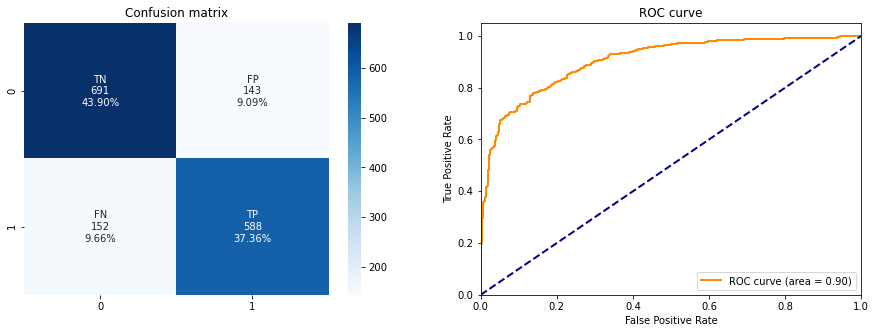

0,812
0,175
0,804
0,794
0,799
0,904


(0.8125794155019059,
 0.1759093619558736,
 0.8043775649794802,
 0.7945945945945946,
 0.7994561522773624,
 0.9044234882364379)

In [14]:
from sklearn.linear_model import LogisticRegression
import utils

print('logistic regression + binary bow')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [15]:
from sklearn.neural_network import MLPClassifier

print('mlp + binary bow')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + binary bow
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


ACC: 0.877
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250


C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


AttributeError: 'MLPClassifier' object has no attribute '_best_coefs'

# TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train['preprocessed_text'])   
X_train = tfidf.transform(df_train['preprocessed_text'])
X_test = tfidf.transform(df_test['preprocessed_text'])

logistic regression + tf-idf
0.48
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       834
           1       0.78      0.87      0.82       740

    accuracy                           0.82      1574
   macro avg       0.82      0.82      0.82      1574
weighted avg       0.83      0.82      0.82      1574

AUC:  0.902158273381295


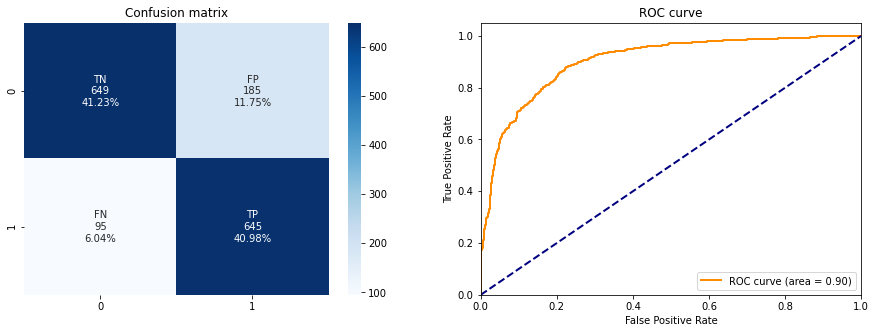

0,822
0,177
0,777
0,871
0,821
0,902


(0.8221092757306226,
 0.17743979721166026,
 0.7771084337349398,
 0.8716216216216216,
 0.821656050955414,
 0.902158273381295)

In [16]:
print('logistic regression + tf-idf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

In [17]:
np.argsort(np.max(lr.coef_, axis=0))[-2]

15405

In [18]:
lr.coef_.min()

-2.1788219618146254

In [19]:
[lr.coef_==0][0][0]

array([False, False, False, ..., False, False, False])

In [21]:
print('words with highest positive value')
for n in range(10):
    k = -n-1
    print(tfidf.get_feature_names()[np.argsort(np.max(lr.coef_, axis=0))[k]])

words with highest positive value
video
audio
pt
compartilhar
repassar
tentar
governar
youtube
rosto_furioso
ver


In [22]:
print('words with lowest negative value')
for n in range(10):
    k = n
    print('\item ' + tfidf.get_feature_names()[np.argsort(np.max(lr.coef_, axis=0))[k]])

words with lowest negative value
\item bolsonaro
\item chat whatsapp
\item chat
\item dia
\item rolando_no
\item rosto_sorridente
\item postar
\item feirar
\item whatsapp
\item bandeira_brasil


mlp + tf-idf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.896
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.885
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.873
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.878
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.878

--------------------
BEST PARAMETERS (validation AUC = 0.896)
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
--------------------
0.46
              precision    recall  f1-score   support

           0       0.86      0.75      0.80       834
           1       0.76      0.86      0.81       740

    accuracy                           0.81      1574
   macro avg       0.81      0.81      0.81      1574
weighted avg       0.81      0.81      0.81      1574

AUC:  0.9024645148745869


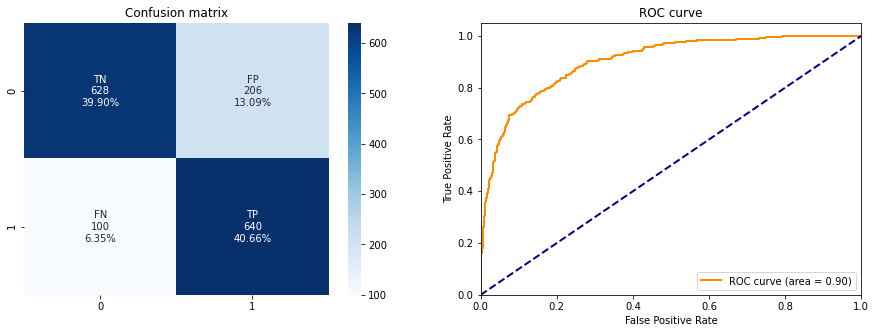

0,805
0,195
0,756
0,864
0,807
0,902


(0.8055908513341804,
 0.19590268886043527,
 0.7565011820330969,
 0.8648648648648649,
 0.807061790668348,
 0.9024645148745869)

In [12]:
print('mlp + tf-idf')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=5)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Word embeddings - Word2Vec

### Create corpus

In [13]:
# df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
# corpus = list(df[df['midia']==0]['text'].unique())
# total_iter = len(corpus)
# divs = 10
# step = int(total_iter/divs)

# preprocessed_corpus = []

# for i, t in enumerate(corpus):
#     if i%step==0:
#         print(str((i/step)*divs)+'%')        
#     preprocessed_corpus.append(preprocess(t))      


In [4]:
import pickle

# with open('data/2018/preprocessed_corpus.p.pickle', 'wb') as handle:
#     pickle.dump(preprocessed_corpus, handle)

preprocessed_corpus = pickle.load( open( "data/2018/preprocessed_corpus.p.pickle", "rb" ) )

In [5]:
len(preprocessed_corpus)

114444

In [15]:
tokens_documents = [p.split() for p in preprocessed_corpus]

### Train word2vec

In [16]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training"""

    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        self.epoch += 1
        print("W2V: Epoch #{}".format(self.epoch))
        
epoch_logger = EpochLogger()

w2v = Word2Vec(sentences=tokens_documents, vector_size=100, epochs=15, window=5, min_count=1, workers=4, 
                 compute_loss=True, callbacks=[epoch_logger])
w2v.save("data/2018/word2vec.model")

W2V: Epoch #1
W2V: Epoch #2
W2V: Epoch #3
W2V: Epoch #4
W2V: Epoch #5
W2V: Epoch #6
W2V: Epoch #7
W2V: Epoch #8
W2V: Epoch #9
W2V: Epoch #10
W2V: Epoch #11
W2V: Epoch #12
W2V: Epoch #13
W2V: Epoch #14
W2V: Epoch #15


### Load and test

In [17]:
w2v = Word2Vec.load("data/2018/word2vec.model")

In [18]:
w2v.wv.most_similar(positive=['facada'])

[('esfaquear', 0.6313445568084717),
 ('barriga', 0.581384539604187),
 ('faca', 0.5806493759155273),
 ('purpurino', 0.5454385280609131),
 ('agressor', 0.5434315800666809),
 ('ferimento', 0.5381067991256714),
 ('abdomen', 0.5290761590003967),
 ('violentar', 0.5071153044700623),
 ('cuspe', 0.5049540400505066),
 ('suspeitar', 0.4996298551559448)]

In [19]:
w2v.wv['deus']

array([-0.8228198 ,  1.2679476 ,  0.7438907 , -2.5204349 , -3.0583067 ,
        1.3230653 ,  1.7405411 ,  4.1464157 ,  1.4382031 ,  1.3566648 ,
        0.21579187, -1.7289222 , -3.4862645 ,  2.340453  ,  0.63076985,
        0.3545946 , -2.5238612 , -1.8874902 , -2.0189822 , -0.4652913 ,
       -1.2481508 , -2.1825945 , -1.6205806 , -0.13788366, -1.6683303 ,
        0.9676989 , -0.22103001, -1.4354798 , -1.927543  ,  1.1750124 ,
       -2.4214036 ,  1.40951   ,  0.71851456, -6.2841096 , -2.062358  ,
       -1.0938251 ,  1.5386039 ,  0.77918357, -5.353897  ,  1.0168374 ,
       -4.7872744 ,  2.8588011 , -0.434115  , -0.27130654,  2.2097251 ,
       -2.5477283 ,  1.175641  ,  1.0129026 ,  2.3452468 ,  3.8153718 ,
       -0.9506817 , -2.585594  , -1.0526263 , -0.16101697, -0.48423928,
       -2.89379   ,  2.9248953 , -0.10294447,  3.2483141 ,  2.3179731 ,
       -0.8723261 ,  2.2416344 , -1.0821999 , -1.3159556 ,  2.7491908 ,
        0.36830887,  3.219854  ,  4.0491214 , -0.35027623,  0.19

### Vectorize

In [20]:
import numpy as np
x = utils.vectorize_corpus(w2v, ['fora bolsonaro genocida'])
x

array([[-0.64791196,  0.22823209,  0.41009811, -0.88481265,  0.12849088,
         0.45800216, -0.51237637,  0.59028507, -0.26614845, -0.38327896,
        -0.33505128, -0.22730707, -0.260784  ,  0.35856693,  0.48157995,
        -0.87243947, -0.1334899 , -0.20189519, -0.28752933,  0.14212631,
        -1.06673587, -0.30539434, -0.7582044 , -0.37193028,  0.1786802 ,
         0.25463497,  0.24086418,  0.54282723,  0.38463237,  0.61386656,
         0.18799024, -0.4951926 , -0.75862749, -0.11404481,  0.67604236,
         0.86758235,  0.19152372,  0.899569  ,  0.28395107,  0.53334206,
        -0.51006625,  0.15025674, -0.64139142,  0.80005412, -0.34621411,
        -0.13885238,  0.25679059,  0.59312302,  0.00133025,  0.26887474,
         0.39564844,  0.25905916,  0.27102109,  0.03800169, -0.09668516,
        -0.35954621, -0.04963822,  0.32595991,  0.38481562,  0.08540367,
         0.05840938, -0.11231369,  0.61592212,  0.21264692,  0.27809913,
         0.3535561 ,  1.18815327, -0.07904865,  0.2

In [21]:
X_train = utils.vectorize_corpus(w2v, df_train['preprocessed_text'])
X_test = utils.vectorize_corpus(w2v, df_test['preprocessed_text'])
#X_train, X_test = utils.z_score(X_train, X_test)

### Classification

logistic regression + w2v
0.45
              precision    recall  f1-score   support

           0       0.78      0.70      0.74       834
           1       0.70      0.78      0.74       740

    accuracy                           0.74      1574
   macro avg       0.74      0.74      0.74      1574
weighted avg       0.74      0.74      0.74      1574

AUC:  0.8041950223604899


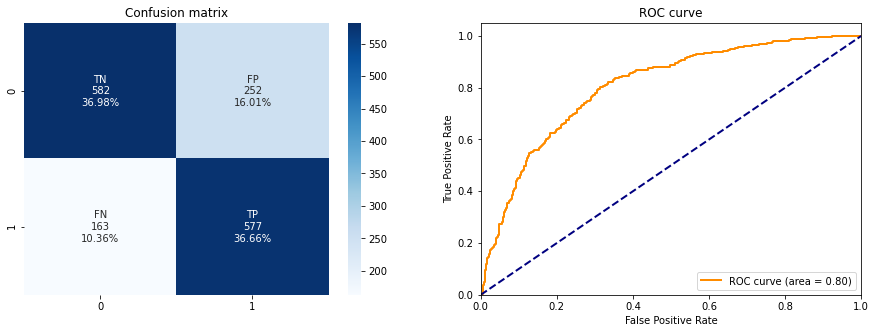

0,736
0,262
0,696
0,779
0,735
0,804


In [22]:
print('logistic regression + w2v')
lrw2v = LogisticRegression()
lrw2v.fit(X_train, y_train)
y_prob = lrw2v.predict_proba(X_test)[:,1]
y_prob_train = lrw2v.predict_proba(X_train)[:,1]
thr = utils.optimal_threshold(y_prob_train,y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
test_metrics = utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

mlp + w2v
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 100
ACC: 0.787
1 
hidden layers: (75, 125); alpha: 0.00002; learning rate: 0.00015; batch: 250
ACC: 0.742
2 
hidden layers: (50, 175, 200); alpha: 0.00013; learning rate: 0.00506; batch: 300
ACC: 0.854
3 
hidden layers: (350, 225); alpha: 0.00000; learning rate: 0.00011; batch: 200
ACC: 0.782
4 
hidden layers: (25, 75); alpha: 0.00008; learning rate: 0.02528; batch: 300
ACC: 0.829
5 
hidden layers: (200, 25, 50); alpha: 0.00000; learning rate: 0.06823; batch: 150
ACC: 0.785
6 
hidden layers: (200,); alpha: 0.00001; learning rate: 0.02102; batch: 250
ACC: 0.819
7 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 250
ACC: 0.809
8 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100
ACC: 0.830
9 
hidden layers: (200, 250); alpha: 0.00757; learning rate: 0.00911; batch: 200
ACC: 0.838

--------------------
BEST PARAMETERS (validation AUC = 0.854)
hidden l

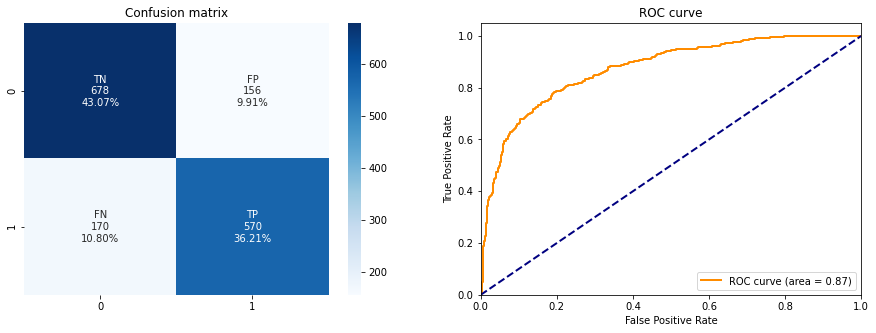

0,792
0,193
0,785
0,770
0,777
0,872


(0.7928843710292249,
 0.19381688466111768,
 0.7851239669421488,
 0.7702702702702703,
 0.7776261937244202,
 0.8724447469051786)

In [23]:
print('mlp + w2v')
hl,bs,al,lri = utils.random_search_mlp(X_train,y_train,n_iter=10)
clf = utils.optimized_mlp(hl,bs,al,lri)
clf.fit(X_train, y_train)

y_prob = clf.predict_proba(X_test)[:,1]
y_prob_train = clf.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)

# Real frequency of test data

In [24]:
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df = df[df['misinformation']!=-1][['text','misinformation']]
df

C:\Users\lucas.carneiro\Anaconda3\envs\env\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,text,misinformation
1,O Bolsonaro tem que estar preparado pra respon...,0
15,"No dia 07 de Outubro, quando for votar, não es...",1
26,Devido a aborrecimentos nas varias redes socia...,0
43,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,Como são as coisas.\nChefe do jacaré aparece n...,1
...,...,...
282555,👏👏👏👏 \nTerminou a apuração dos votos no JAPÃO ...,0
282556,https://youtu.be/UwDXPrFkU7M\n\n😡Notícias URGE...,1
282558,https://m.facebook.com/story.php?story_fbid=19...,0
282564,#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17\n#B17...,1


In [25]:
total_texts = []
total_mis = []

for t in df_test['text']:
    q = df[df['text']==t]
    duplicates = len(q)
    if duplicates == 0:
        continue
    
    total_texts += [t]*duplicates
    total_mis += list(q['misinformation'])
    

In [26]:
df_test_real = pd.DataFrame({'text':total_texts, 'misinformation':total_mis})
print('real world size of test data:',len(df_test_real))

real world size of test data: 4346


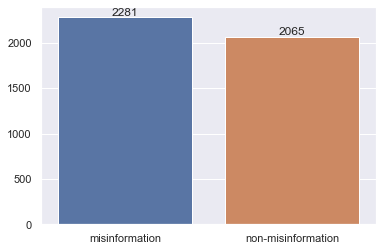

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="darkgrid")

def print_class_balance(y):
    pos_mask = y == 1 
    pos = y[pos_mask]
    neg_mask = y == 0 
    neg = y[neg_mask]
    values = [pos.shape[0],neg.shape[0]]
    keys = ['misinformation', 'non-misinformation']
    g = sns.barplot(x = keys, y = values)
    for p in g.patches:
        g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                                   p.get_height()), ha = 'center', 
                   va = 'center', xytext = (0, 5), textcoords = 'offset points')
        
print_class_balance(df_test_real['misinformation'])

In [28]:
df_test_real['preprocessed_text'] = [preprocess(t) for t in df_test_real['text']]

logistic regression + tf-idf
0.48
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      2065
           1       0.80      0.84      0.82      2281

    accuracy                           0.81      4346
   macro avg       0.81      0.81      0.81      4346
weighted avg       0.81      0.81      0.81      4346

AUC:  0.8913933717105089


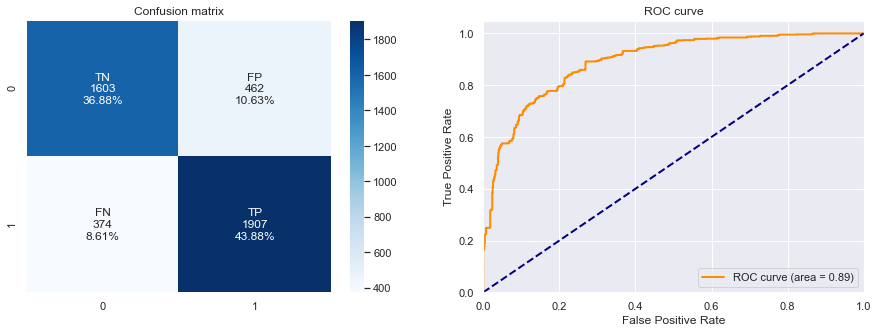

0,807
0,206
0,804
0,836
0,820
0,891


(0.8076392084675563,
 0.2068283028203859,
 0.8049810046433095,
 0.8360368259535291,
 0.8202150537634408,
 0.8913933717105089)

In [29]:
tfidf = TfidfVectorizer(max_features = None, ngram_range = (1,2), #(1,3) 
                             lowercase = False, token_pattern = r'[^\s]+',binary=True)

tfidf.fit(df_train['preprocessed_text'])   
X_train = tfidf.transform(df_train['preprocessed_text'])
X_test = tfidf.transform(df_test_real['preprocessed_text'])
y_train = df_train['misinformation']
y_test = df_test_real['misinformation']

print('logistic regression + tf-idf')
lr = LogisticRegression()
lr.fit(X_train, y_train)

y_prob = lr.predict_proba(X_test)[:,1]
y_prob_train = lr.predict_proba(X_train)[:,1]
# threshold moving

thr = utils.optimal_threshold(y_prob_train, y_train)
print(thr)
y_pred = [1 if p >= thr else 0 for p in y_prob]
utils.get_test_metrics(y_test, y_pred, y_prob, full_metrics = True)